# Individual Plot

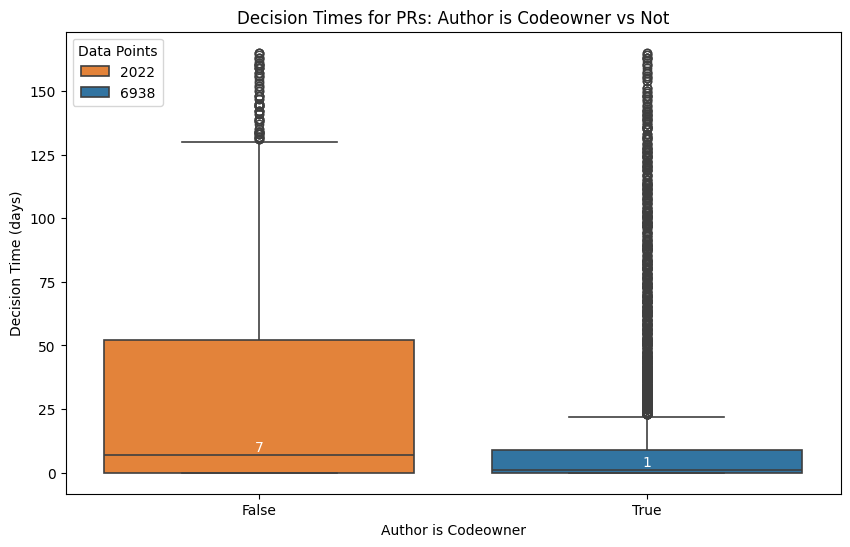

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# change path back
with open('../data/CODEOWNERS.txt') as file:
    lines = file.readlines()
    codeowners = [line.strip() for line in lines if line.strip() and not line.startswith('#')]

df = pd.read_csv("../data/pull_requests_filtered.csv")
new_feature_prs = df[df['Type of Change'].str.contains('New feature')]
decision_times = new_feature_prs['Decision Time']

def is_any_code_owner(row):
    author = row["Author"]

    return any([str(author) in line for line in lines])

df["Author is Codeowner"] = df.apply(is_any_code_owner, axis=1)     # axis=1 applies function to each row

upper_limit = df['Decision Time'].quantile(0.95)
df = df[df['Decision Time'] <= upper_limit]

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Author is Codeowner', y='Decision Time', data=df, linewidth=1.2, palette={True: "#1f77b4", False: "#ff7f1e"}, hue='Author is Codeowner', legend=False)

medians = df.groupby('Author is Codeowner')['Decision Time'].median()
for tick, median in zip(ax.get_xticks(), medians):
    ax.text(tick, median + 1.5, f'{int(median)}', horizontalalignment='center', size=10, color='white')

counts = df['Author is Codeowner'].value_counts()
plt.legend(title='Data Points', loc='upper left', labels=[counts.get(False), counts.get(True)])

plt.xlabel('Author is Codeowner')
plt.ylabel('Decision Time (days)')
plt.title('Decision Times for PRs: Author is Codeowner vs Not')

# plt.savefig('../plot-images/decision_time_with_codeowners.png')
plt.show()


# Combined Plot

/var/folders/43/b6b58k292659_t5j2lbklx6c0000gn/T/ipykernel_82472/2598856714.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(["Non-codeowner", "Codeowner"])


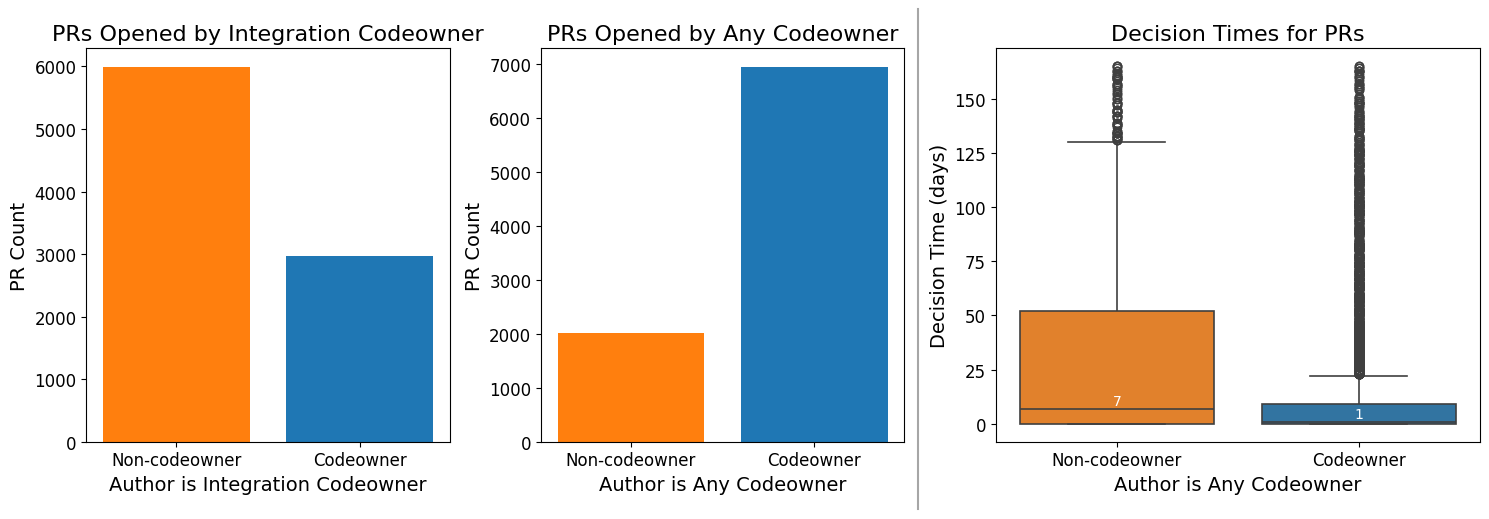

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CODEOWNERS file
with open('../data/CODEOWNERS.txt') as file:
    lines = file.readlines()
    codeowners = [line.strip() for line in lines if line.strip() and not line.startswith('#')]

df = pd.read_csv("../data/pull_requests_filtered.csv")

# Filter new feature PRs
new_feature_prs = df[df['Type of Change'].str.contains('New feature')]
decision_times = new_feature_prs['Decision Time']

# Create codeowner mappings
codeowner_map = {}
for line in codeowners:
    parts = line.split()
    path = parts[0]
    owners = [username.lstrip('@') for username in parts[1:]]

    if path.startswith("/homeassistant/components/"):
        integration = path.split('/')[3]
        codeowner_map[integration] = set(owners)

# Check if author is a codeowner for integration
def is_code_owner(row):
    integration = row["Integration"]
    author = row["Author"]
    return integration in codeowner_map and author in codeowner_map[integration]

# Check if author is any codeowner
def is_any_code_owner(row):
    author = row["Author"]
    return any([str(author) in line for line in lines])

df["Author is Codeowner"] = df.apply(is_code_owner, axis=1)
df["Author is Any Codeowner"] = df.apply(is_any_code_owner, axis=1)

# Remove outliers
upper_limit = df['Decision Time'].quantile(0.95)
df = df[df['Decision Time'] <= upper_limit]

# Aggregate counts
codeowner_counts = df.groupby("Author is Codeowner").count()
codeowner_any_counts = df.groupby("Author is Any Codeowner").count()



# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [0.3, 0.3, 0.4]})

# First bar plot
axs[0].bar(["Non-codeowner", "Codeowner"], codeowner_counts["LOC Changed"], color=["#ff7f0e", "#1f77b4"])
axs[0].set_title('PRs Opened by Integration Codeowner')
axs[0].set_xlabel('Author is Integration Codeowner')
axs[0].set_ylabel('PR Count')

# Second bar plot
axs[1].bar(["Non-codeowner", "Codeowner"], codeowner_any_counts["LOC Changed"], color=["#ff7f0e", "#1f77b4"])
axs[1].set_title('PRs Opened by Any Codeowner')
axs[1].set_xlabel('Author is Any Codeowner')
axs[1].set_ylabel('PR Count')

fig.add_artist(plt.Line2D([0.615, 0.615], [0.00, 1.00], 
                         transform=fig.transFigure, 
                         color='gray', 
                         linestyle='solid', 
                         linewidth=1.5, 
                         alpha=0.7))

# Boxplot
sns.boxplot(
    x='Author is Any Codeowner',
    y='Decision Time',
    data=df,
    linewidth=1.2,
    palette={True: "#1f77b4", False: "#ff7f0e"},
    hue='Author is Any Codeowner',
    legend=False,
    ax=axs[2]
)
axs[2].set_xticklabels(["Non-codeowner", "Codeowner"])

# Add median labels
medians = df.groupby('Author is Any Codeowner')['Decision Time'].median()
for tick, median in zip(axs[2].get_xticks(), medians):
    axs[2].text(tick, median + 1.5, f'{int(median)}', horizontalalignment='center', size=10, color='white')

# Format boxplot
axs[2].set_xlabel('Author is Any Codeowner')
axs[2].set_ylabel('Decision Time (days)')
axs[2].set_title('Decision Times for PRs')

title_fontsize = 16
axis_label_fontsize = 14
tick_fontsize = 12

# Apply to all subplots
for ax in axs:
    # Set title font size
    ax.set_title(ax.get_title(), fontsize=title_fontsize)
    
    # Set x and y axis label font sizes
    ax.set_xlabel(ax.get_xlabel(), fontsize=axis_label_fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=axis_label_fontsize)
    
    # Set tick font sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Adjust layout and save
plt.tight_layout()
# plt.savefig('plot-images/combined_codeowner_analysis.png')
plt.show()
